# Tracy Michaels
## Data Mining - Assignment 5


##### pre-pro:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

In [2]:
def load_data_and_format(file_name: str) -> list:
    """
    Loads data from file; parses data and formats it into proper 2d array
    for neural network
    
    Input: String -- file name must be .txt file and in same location as program file
    
    TODO: extend to add optional path location as second parameter     
    
    Output: List of lists of floats and integers 
    """
    f = open(f'./{file_name}.txt', 'r')
    data = f.read().splitlines()
    f.close()
    data = [i.split() for i in data]
    return [[float(j) for j in i[:-1]]+[int(i[-1])] for i in data]

In [3]:
# load and prepare data
filenames = ['dataset1_training', 'dataset1_testing', 'dataset2_training', 'dataset2_testing']
for i in filenames:
    globals()[f'{i}'] = load_data_and_format(i)

### problem 1 -  Implementing a Neural Network using BackPropogation 

In [4]:
# from tutorial 
# https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

# TODO - time permiting - turn into a class so I can use the same function to display both this and the SVC
# might involve updating the predict function too to handle a list instead of a single data point at a time

from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp


# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(neuron['output'] - expected[j])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] -= l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

In [5]:
def display_nn(train: list, test: list, title: str, n_hidden: int, n_out: int):
    """
    this function performs the initialization and training of a neural network with backpropagation
    then displays the training and testing data points on a graph overlayed with the decision boundry of that
    network as well as its accuracy
    
    Input: 
        train: list
            - list of training datapoints
        test: list
            - list of testing datapoints
        title: str
            - super title of graph
        n_hidden: int
            - number of hidden layers
        n_out: int
            - number of outputs
    
    """
    X_train = np.array([i[:-1] for i in train])
    y_train = [i[-1] for i in train]
    X_test = np.array([i[:-1] for i in test])
    y_test = [i[-1] for i in test]
    # step size for decision boundry
    h = 0.01

    # init, train and predict with neural network
    nn = initialize_network(len(train[0]) - 1, n_hidden,  n_out)
    train_network(nn, train, 0.8, 500, n_out)
    predictions = [predict(nn, i) for i in test]

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary based on training data
    fig, axarr = plt.subplots(1, 2, figsize=(16, 8))
    bound_pred = [predict(nn, i) for i in np.c_[xx.ravel(), yy.ravel()]]

    Z = np.array(bound_pred)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    for ax in axarr:
        ax.contourf(xx, yy, Z)
        ax.axis('off')

    # Plot training and testing points
    axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker ='.')
    axarr[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, marker='x')
    axarr[0].set_title('train')
    axarr[1].set_title('test')
    plt.suptitle(f'{title} - Hidden Layers: {n_hidden}')
    plt.show()    
    
    print(f'{title} Accuracy: {accuracy_metric(y_test, predictions)}')
    print()

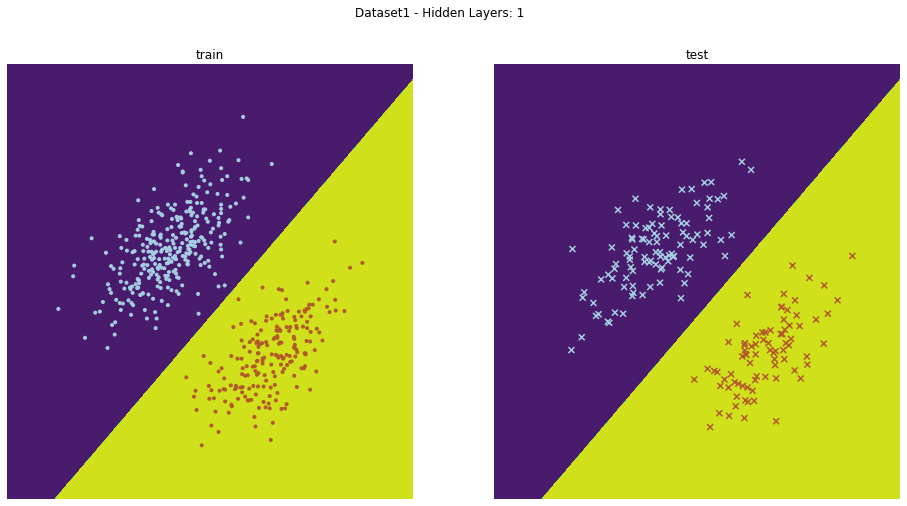

Dataset1 Accuracy: 100.0



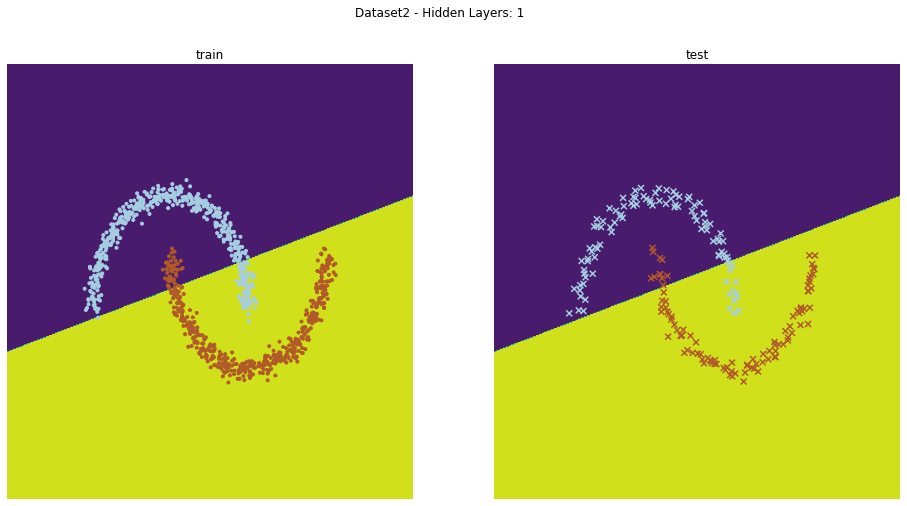

Dataset2 Accuracy: 88.0



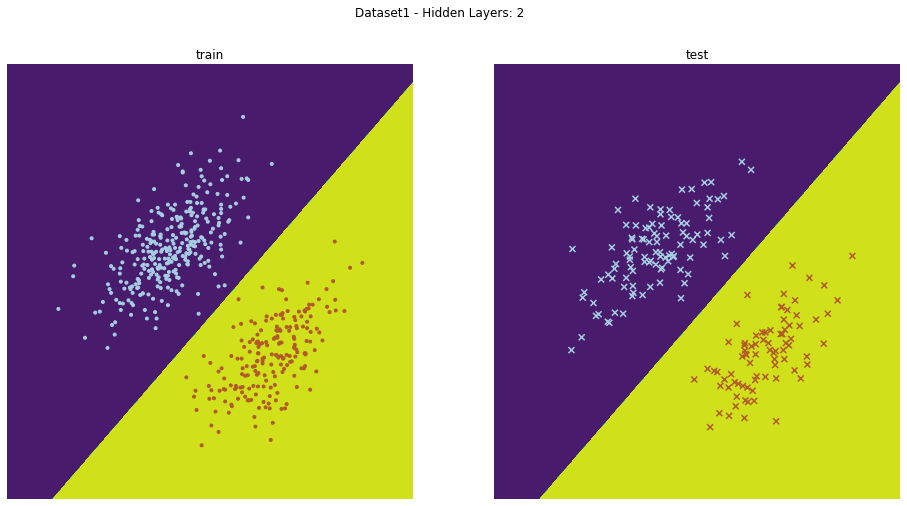

Dataset1 Accuracy: 100.0



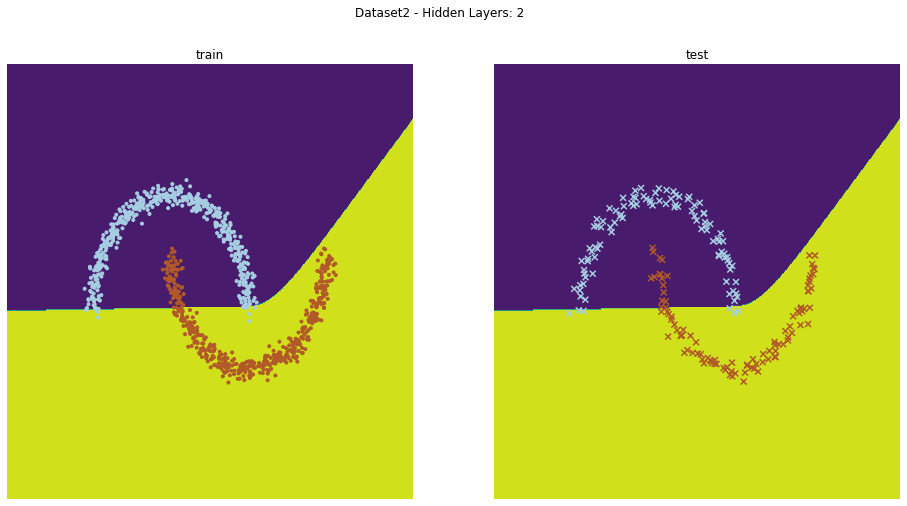

Dataset2 Accuracy: 89.0



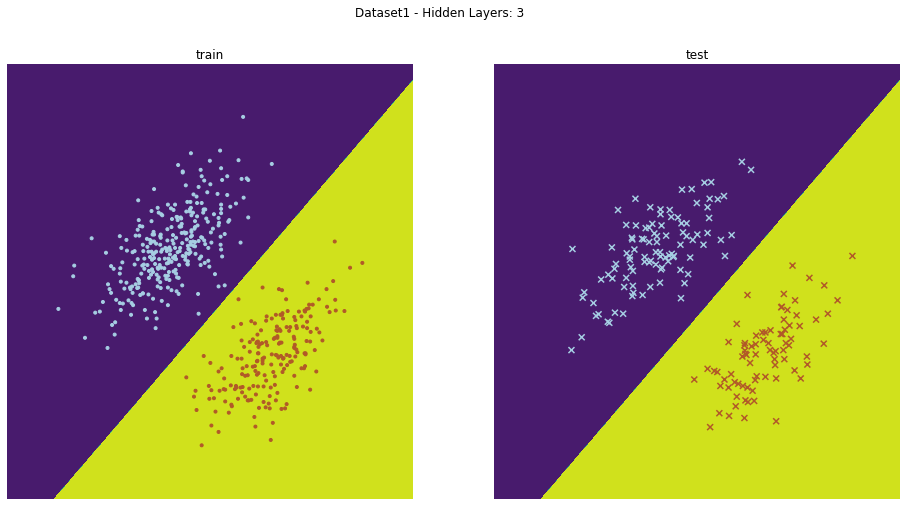

Dataset1 Accuracy: 100.0



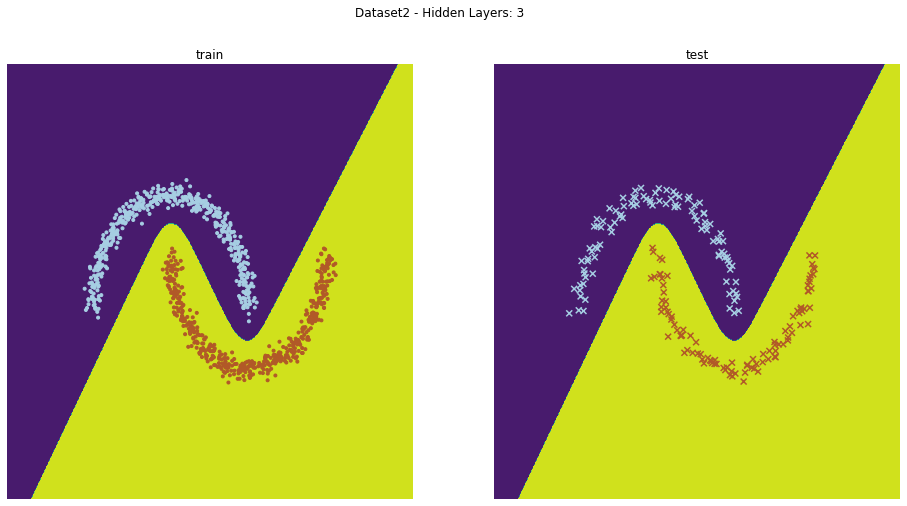

Dataset2 Accuracy: 100.0



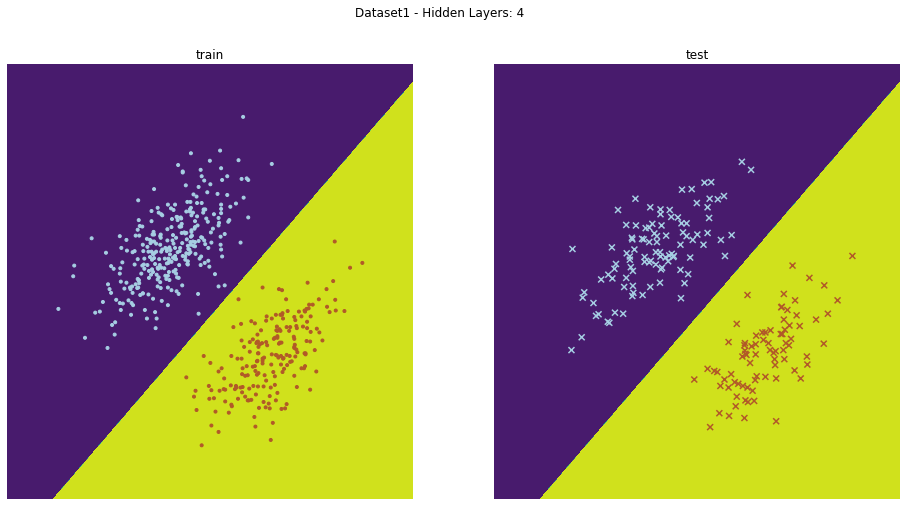

Dataset1 Accuracy: 100.0



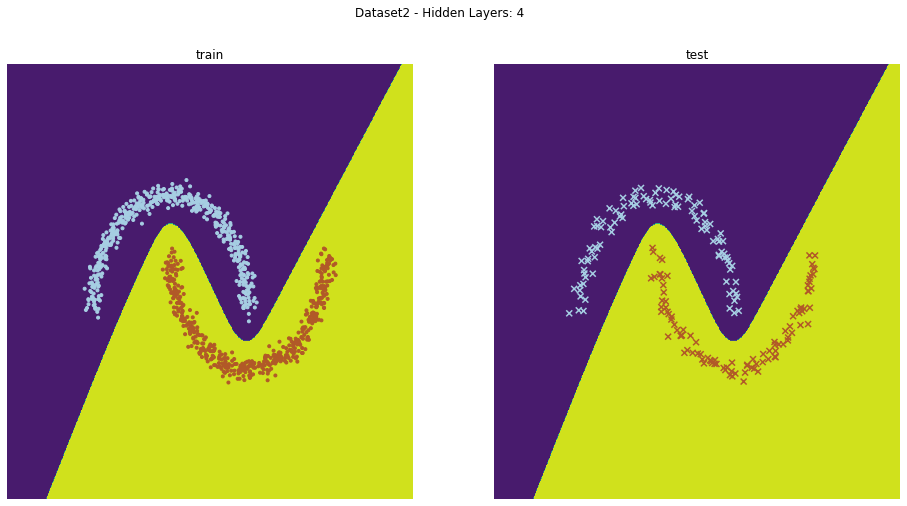

Dataset2 Accuracy: 100.0

Wall time: 1min 12s


In [6]:
%%time

for i in range(1, 5):
    display_nn(dataset1_training, dataset1_testing, 'Dataset1', i, 2)
    display_nn(dataset2_training, dataset2_testing, 'Dataset2', i, 2)

### Problem 2 solution - SMV

In [7]:
def display_SVM(train: list, test: list, title: str, kern: str):
    """
    this function performs the initialization and training of a support vector machine with given kernals
    then displays the training and testing data points on a graph overlayed with the decision boundry of that
    network as well as its accuracy
    
    Input: 
        train: list
            - list of training datapoints
        test: list
            - list of testing datapoints
        title: str
            - super title of graph
        kernal: str
            - type of kernal to be used by the classifier
    
    """
    X_train = np.array([i[:-1] for i in train])
    y_train = [i[-1] for i in train]
    X_test = np.array([i[:-1] for i in test])
    y_test = [i[-1] for i in test]
    # step size for decision boundry
    h= 0.01

    clf = svm.SVC(kernel=kern, gamma='auto')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)


    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary based on training data
    fig, axarr = plt.subplots(1, 2, figsize=(16, 8))
    bound_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(bound_pred)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    for ax in axarr:
        ax.contourf(xx, yy, Z)
        ax.axis('off')

    # Plot training and testing points
    axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker ='.')
    axarr[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, marker='x')
    axarr[0].set_title('train')
    axarr[1].set_title('test')
    plt.suptitle(f'{title}, Kernel: {kern}')
    plt.show()    
    
    print(f'{title} Accuracy: {accuracy_metric(y_test, pred)}')
    print()

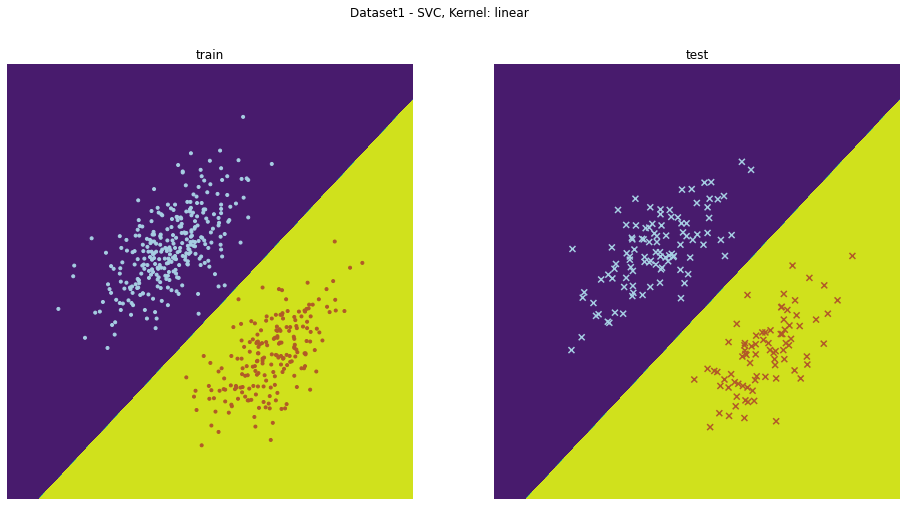

Dataset1 - SVC Accuracy: 100.0



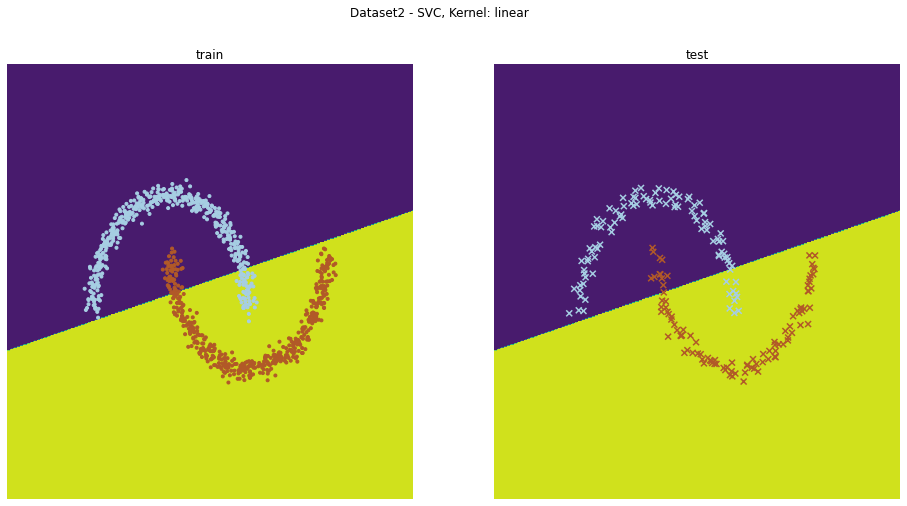

Dataset2 - SVC Accuracy: 89.0



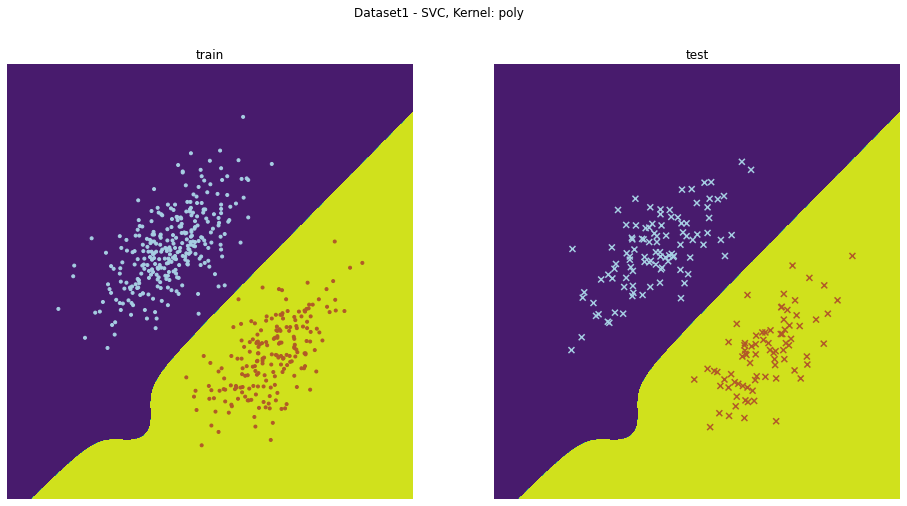

Dataset1 - SVC Accuracy: 100.0



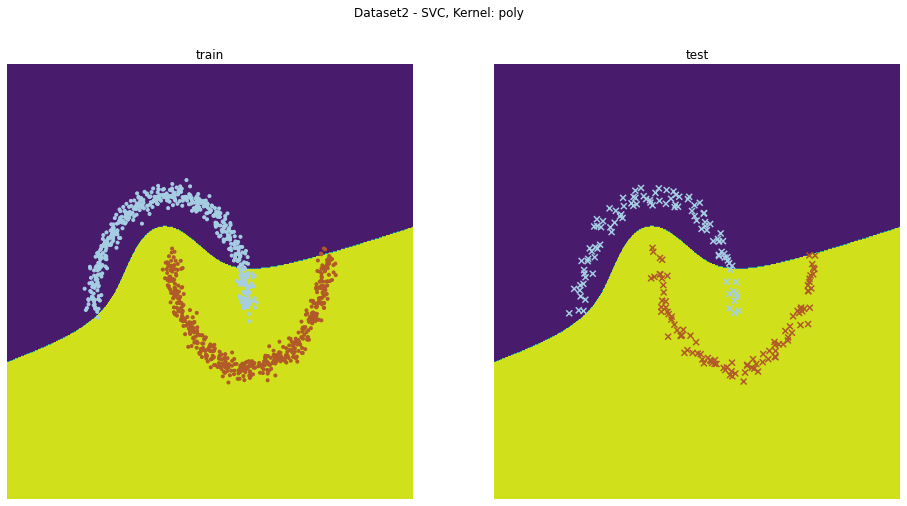

Dataset2 - SVC Accuracy: 94.0



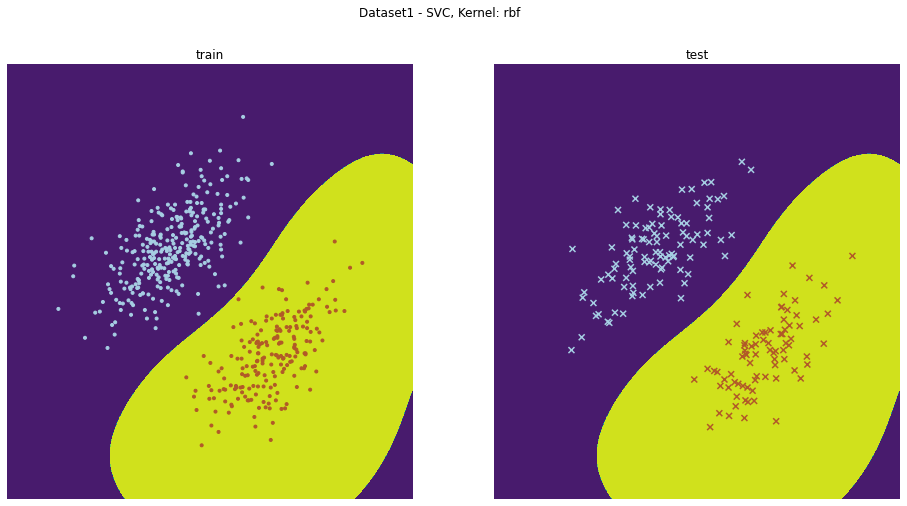

Dataset1 - SVC Accuracy: 100.0



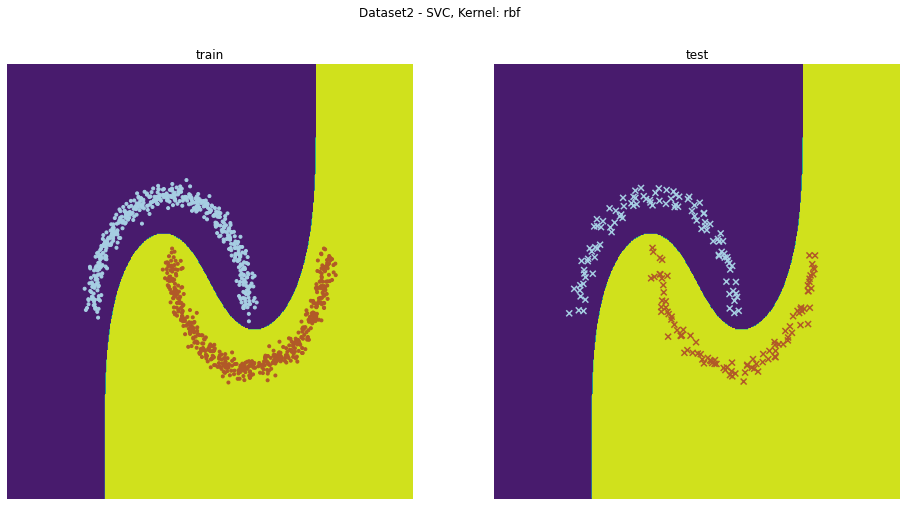

Dataset2 - SVC Accuracy: 100.0



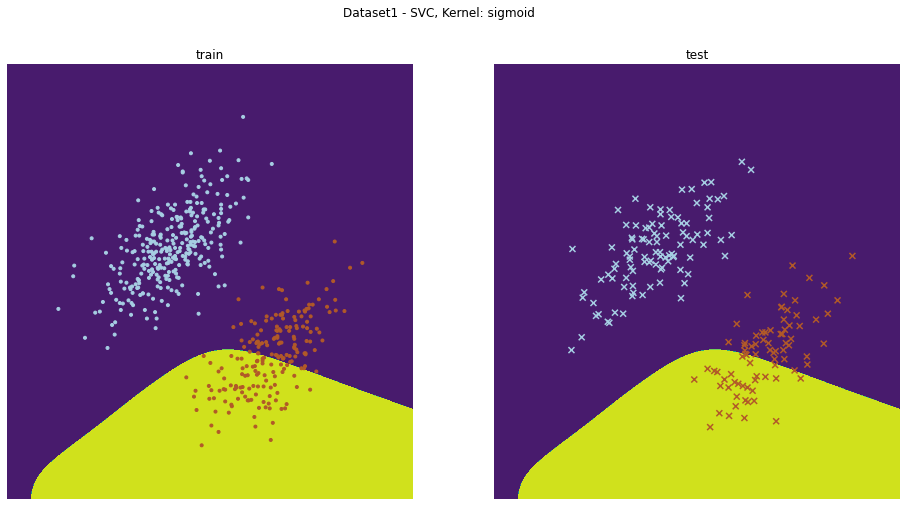

Dataset1 - SVC Accuracy: 73.33333333333333



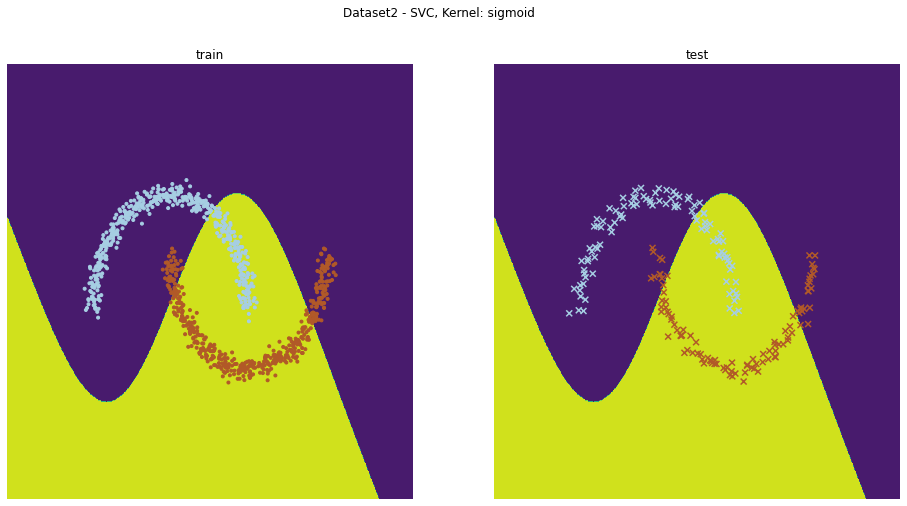

Dataset2 - SVC Accuracy: 67.0

Wall time: 22.8 s


In [8]:
%%time
kernals = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kernals:
    display_SVM(dataset1_training, dataset1_testing, 'Dataset1 - SVC', i)
    display_SVM(dataset2_training, dataset2_testing, 'Dataset2 - SVC', i)